In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split

from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
jtplot.style()

In [2]:
data = pd.read_csv('train.csv')
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Columns: 133 entries, ID to v131
dtypes: float64(108), int64(6), object(19)
memory usage: 116.0+ MB


In [4]:
# Уменьшим размер данных для ускорения обучения, возьмем случайную подвыборку 20% данных
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

In [5]:
# Разбиваем на train/test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

In [6]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3         3
v22     6610
v24        5
v30        7
v31        3
v47        9
v52       12
v56       90
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      22
v113      34
v125      88
dtype: int64


In [7]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

In [8]:
from sklearn.tree import DecisionTreeRegressor

clf_tree = DecisionTreeRegressor(max_depth=15, min_samples_leaf=20)
clf_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=20)

In [9]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

Train:
ROC AUC: 0.8587
Test:
ROC AUC: 0.6479


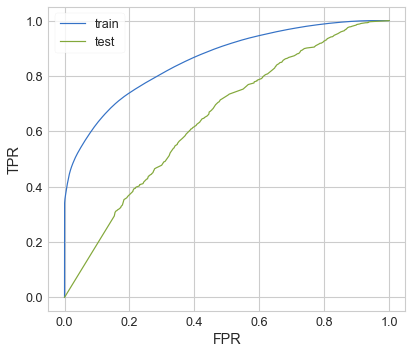

In [10]:
y_pred_test = clf_tree.predict(X_test)
y_pred_train = clf_tree.predict(X_train)

print('Train:')
show_auc(y_train, y_pred_train, 'train')
         
print('Test:')
show_auc(y_test, y_pred_test, 'test')

plt.legend();

In [11]:
clf_tree.score(X_train, y_train)

0.31939112767793454

In [12]:
clf_tree.score(X_test, y_test) # отрицательное значение выглядит странно..

-0.04236576259472513

In [13]:
MSE = np.sum((y_train - clf_tree.predict( X_train )) ** 2)
MSE

1980.0987729654444

In [14]:
MSE = np.sum((y_test - clf_tree.predict( X_test )) ** 2)
MSE

1299.710978439897

**Случайный лес**

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
clf_rf = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=0.5, min_samples_leaf=20,
                      n_estimators=10, n_jobs=-1)

Train RF:
ROC AUC: 0.7507
Test RF:
ROC AUC: 0.7249


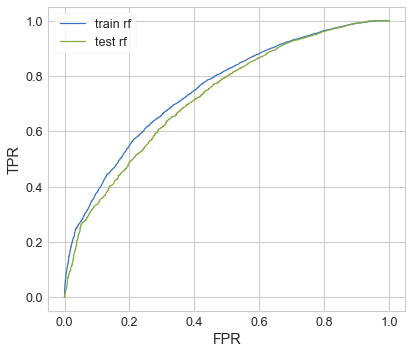

In [17]:
y_pred_test_rf = clf_rf.predict(X_test)
y_pred_train_rf = clf_rf.predict(X_train)


print('Train RF:')
show_auc(y_train, y_pred_train_rf, 'train rf')
print('Test RF:')
show_auc(y_test, y_pred_test_rf, 'test rf')

plt.legend();



**Оценка важности фичей**

In [18]:
imp = pd.Series(clf_rf.feature_importances_)
imp.sort_values(ascending=False)

43     0.485055
149    0.082047
117    0.055994
167    0.041902
178    0.041001
         ...   
175    0.000000
179    0.000000
101    0.000000
98     0.000000
218    0.000000
Length: 219, dtype: float64

<BarContainer object of 219 artists>

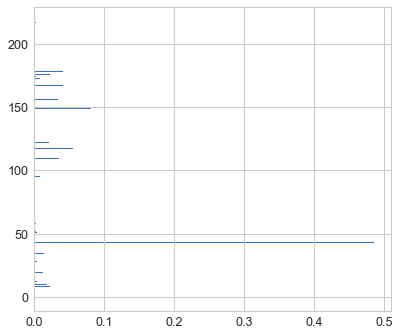

In [19]:
plt.barh(np.arange(len(clf_rf.feature_importances_)), clf_rf.feature_importances_)

**Стекинг**

In [20]:
from sklearn.preprocessing import StandardScaler  # стандартизация набора данных

train_median = d_train[num_feat].median()

X_train = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train[num_feat])

X_train[num_feat] = scaler.transform(X_train[num_feat])
X_test[num_feat] = scaler.transform(X_test[num_feat])

In [21]:
from sklearn.ensemble import StackingRegressor

In [24]:
regressor = StackingRegressor(
    [
        ('dt', DecisionTreeRegressor()),
        ('lir', LinearRegression()),
        ('RCV', RidgeCV())
       
    ],
RidgeCV())

In [25]:
regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('dt', DecisionTreeRegressor()),
                              ('lir', LinearRegression()),
                              ('RCV',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ])))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [27]:
y_pred_proba_dt = regressor.named_estimators_['dt'].predict(X_test)
y_pred_proba_lir = regressor.named_estimators_['lir'].predict(X_test)
y_pred_proba_RCV = regressor.named_estimators_['RCV'].predict(X_test)

In [29]:
y_pred_proba = regressor.predict(X_test)

DT
ROC AUC: 0.5760
LiR
ROC AUC: 0.7132
RCV
ROC AUC: 0.5760
STACK
ROC AUC: 0.7153


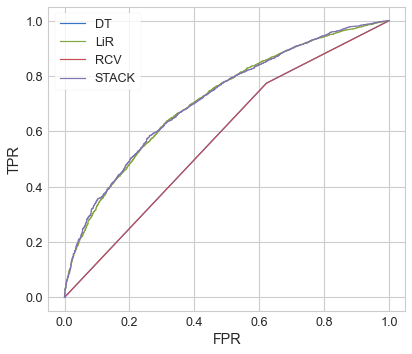

In [31]:
print("DT")
show_auc(y_test, y_pred_proba_dt, 'DT')
print("LiR")
show_auc(y_test, y_pred_proba_lir, 'LiR')
print("RCV")
show_auc(y_test, y_pred_proba_dt, 'RCV')
print("STACK")
show_auc(y_test, y_pred_proba, 'STACK')
plt.legend()
plt.show()